# **Elasticity equations**
**Johan Hoffman**

**Lab made by:** Frida Svelander, \\
**In collaboration with:** Joel Kronborg

# **Abstract**

In this short report I present my solution to the lab on the Elasticity equation in the course DD2365/FDD3371 Advanced Computation in Fluid Mechanics at KTH Royal Institute of Technology. I have used the FEniCS software with Python in Google Colab to solve a set of problems related to elastic mesh deformation, Poisson's ratio and Young's modulus. 

The elasticity equation is solved in response to prescribed movement of three cylindrical holes in the mesh, and a displacement field is calculated for the mesh. Young's modulus and Poisson's ratio are varied and the effect on the node displacement is investigated. It is verified that the mesh deforms in accordance with the displacement, and that the Poisson ratio has the largest effect on the deformation.  

# **Introduction**

The Elasticity equations take the form

$-\nabla \cdot \sigma = f$

together with suitable boundary conditions.

To derive the weak form of the equations, multiply the equation by $v\in V$, and then integrate over the domain $\Omega$ and use Green's formula
$
(-\nabla \cdot \sigma ,v) = (\nabla \sigma , \nabla v) 
- <\sigma \cdot n, v>_{\Gamma}
$

To model 

We seek a finite element approximation $u\in V$ such that 

$(\nabla \sigma,\nabla v) - <\sigma \cdot n, v>_{\partial \Omega} = (f,v)$

for all test functions $v \in V$. 



# **Method**


We use FEniCS with Python in Google Colab to solve the elasticity equations in 2D with the finite element method. The FEniCS environment is first loaded. 


In [223]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS
try:
    import dolfin
except ImportError as e:
    !apt-get install -y -qq software-properties-common
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    !sed -i "s|#if PETSC_VERSION_MAJOR == 3 && PETSC_VERSION_MINOR <= 8 && PETSC_VERSION_RELEASE == 1|#if 1|" /usr/include/dolfin/la/PETScLUSolver.h
    !rm -rf /usr/lib/python3/dist-packages/mpi4py*
    !rm -rf /usr/lib/python3/dist-packages/petsc4py*
    !rm -rf /usr/lib/python3/dist-packages/slepc4py*
    !rm -rf /usr/lib/petsc/lib/python3/dist-packages/dolfin*
    !rm -rf /usr/lib/petsc/lib/python3/dist-packages/mshr*
    !wget "https://drive.google.com/uc?export=download&id=1cT_QBJCOW_eL3BThnval3bcpb8o0w-Ad" -O /tmp/mpi4py-2.0.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=119i49bxlGn1mrnhTNmOvM4BqmjrT9Ppr" -O /tmp/petsc4py-3.7.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-1tVfu8qz3bRC2zvR8n3RESpesWqNnn6" -O /tmp/slepc4py-3.7.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-3qY4VIJQaXVO1HfGQIzTIURIeJbvX-9" -O /tmp/fenics_dolfin-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-5SMjgjMuee_9WLeYtGe8N_lvipWEN7W" -O /tmp/mshr-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl
    !pip3 install /tmp/mpi4py-2.0.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/petsc4py-3.7.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/slepc4py-3.7.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/fenics_dolfin-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/mshr-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 -q install --upgrade sympy
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

**Define domain and mesh**

We define the domain ant the triangle mesh with resolution h=1/32 and three circular holes of radius 0.2 close to the inlet of the channel.   

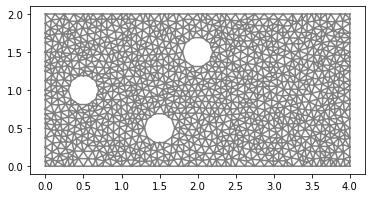

In [224]:
# Define rectangular domain 
L = 4.0
H = 2.0

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0) 

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)
      
left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh (examples with and without a hole in the mesh) 
resolution = 32
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(1.5,0.25*H),0.2) - Circle(Point(0.5,0.5*H),0.2) - Circle(Point(2.0,0.75*H),0.2), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(1.5, 0.5)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

Next, we define the finite element space on which we seek the solution to the variational formulation of the elasticity equation, and we define the displacement vector d in the approximation space.

In [225]:
# Generate finite element space
VE = VectorElement("CG", mesh.ufl_cell(), 1)

V = FunctionSpace(mesh, VE)

# Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V) 

d = Function(V)

**Define boundary conditions**

Next we define the bouncary conditions for the elasticity problem.  

In [226]:
# Define boundary conditions 
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0) 

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

bcu_left0 = DirichletBC(V.sub(0), 0.0, dbc_left)
bcu_left1 = DirichletBC(V.sub(1), 0.0, dbc_left)
bcu_right0 = DirichletBC(V.sub(0), 0.0, dbc_right)
bcu_right1 = DirichletBC(V.sub(1), 0.0, dbc_right)
bcu_upper0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
bcu_upper1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
bcu_lower0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
bcu_lower1 = DirichletBC(V.sub(1), 0.0, dbc_lower)


We force a horizontal and vertical displacement on the cylinders as Dirichlet BC:s. These are varied to investigate the effect on the deformed mesh.

In [227]:
# Investigate the effect on the mesh deformation on the cylinder movement
# Displacement is prescribed by a Dirichlet condition at the cylinders
bcu_obj0 = DirichletBC(V.sub(0), 0.5, dbc_objects)
#bcu_obj0 = DirichletBC(V.sub(0), -0.2, dbc_objects)
#bcu_obj0 = DirichletBC(V.sub(0), 1.5, dbc_objects)
bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)
#bcu_obj1 = DirichletBC(V.sub(1), 0.2, dbc_objects)

#bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
bcu = [bcu_left0, bcu_left1, bcu_right0, bcu_right1, bcu_upper0, bcu_upper1, bcu_lower0, bcu_lower1, bcu_obj0, bcu_obj1]


**Define and solve variational problem**

Next, we define and solve the variational problem for the elasticity equation. We introduce constitutive laws for stress $\sigma$ and strain $\varepsilon$ in terms of Poisson's ratio and Young's modulus. We solve for a displacement vector in response to applied stress.  

In [228]:
f = Expression(("0.0","0.0"), element = V.ufl_element())

dim = u.geometric_dimension()
E = 1.0e10 # Young's modulus - stiffness of the mesh material
# E = 1.0e-3 #1.0e5 # 1.0e9 # Less stiff material - does not affect the mesh deformation
# E = 1.0e20 # 1.0e12 # Stiffer material - does not affect the mesh deformation

# Poisson's ratio - deformation perpendicuar to applied force
nu = 0.3 # stainless steel 
# nu = 0.0 # cork
# nu = 0.499 # rubber # triangles are more deformed when the Poissonäs ratio is increased
mu = E*0.5/(1+nu)
lambda_ = nu*E/((1.0+nu)*(1.0-2.0*nu))

def epsilon(u):
    return 0.5*(grad(u) + grad(u).T)

def sigma(u):
    #return 2.0*mu*epsilon(u)
    return lambda_*div(u)*Identity(dim) + 2.0*mu*epsilon(u)

# Define variational problem on residual form: r(u,v) = 0
residual = ( inner(sigma(u), epsilon(v))*dx - inner(f, v)*dx )

au = lhs(residual)
Lu = rhs(residual)

A = assemble(au)
b = assemble(Lu)

[bc.apply(A, b) for bc in bcu]
[bc.apply(d.vector()) for bc in bcu]

solve(A, d.vector(), b, "bicgstab", "default")

18

We plot the displacement field and correspoding deformed mesh. 

**Visualize solution and export files**

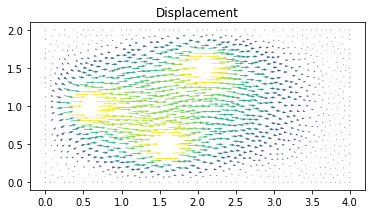

In [229]:
u1 = project(d, V)

# Plot solution
plt.figure()
plot(u1, title="Displacement")

plt.show()

**Update mesh**

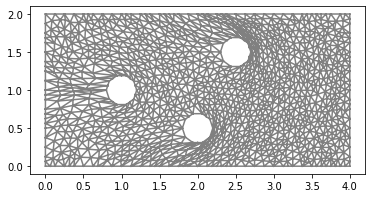

In [230]:
ALE.move(mesh, d)
plt.figure()
plot(mesh)
plt.show()

# **Results**

We note from the plot of the deformed mesh how the triangles are stretched and compressed in response to the displacement of the cylinders. The mesh is deformed to capture the new (displaced) domain. In the default case, the Poisson ratio $\nu=0.3$, and the Young's modulus $E=10^{10}$. 

Varying Young's modulus between $10^{-3}-10^{20}$ does not change the resulting mesh deformation particularly. However, Poisson's ratio has a notable effect on the triangles in the deformed mesh. See Fig. 1. 

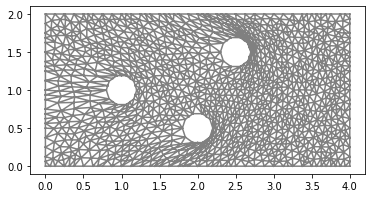 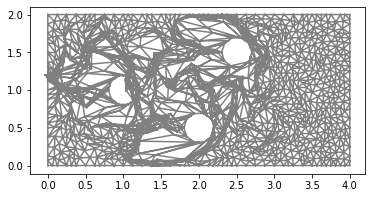

**Fig. 1.** Deformed mesh when Poisson's ratio $\nu=0$ (left) and $\nu=0.499$ (right), corresponding to cork and rubber mesh material, respectively. 

From the figure we can see that the mesh elasticity deformation method is not suitable for materials of very high Poisson's ratio. The mesh to the right in Fig. 1. has very poor quality.

We also vary the displacement of the cylinders by changing the Dirichlet BC:s $\texttt{bcu_obj0}$ and $\texttt{bcu_obj1}$, which enforce the horizontal and vertical displacements respectively. The elastically deformed mesh resulting when the displacement vector is $(1.5, 0.0)$ is visualized in Fig. 2. The Poisson's ratio and Young's modulus are reset to the default values. 

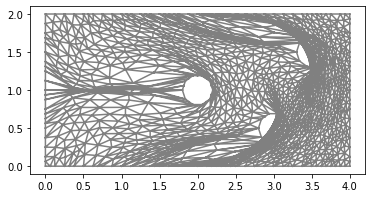

**Fig.2.** Elastically deformed mesh at large cylinder displacement. Horizontal displacement 1.5 and veritcal displacement 0.0.

From Fig. 2. we can see that the elasticity deformation method is not suitable for very large deformations. It would have been better to do a remesh, in this case.

# **Discussion**

An Elasticity equation was solved with a finite element method. We varied Poisson's ratio and Young's modulus to find out that domains with large Poisson ratio are sensible to the particular linear elasticity mesh deformation method. Also large displacements tend to result in deformed meshes of low quality. For small deformations and moderate Poisson ratios, the elasticity deformation method results in ok triangle meshes that capture the displaced domain. Young's modulus does not affect the quality of the deformed mesh.    